In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [3]:
location = '/net/vdesk/data2/deklerk/GAAP_data'
field = '53.0_-28.0'

In [4]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[0]
reference_wcs = WCS(hdu.header)
ra_reference, dec_reference = reference_wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0, ra_dec_order=True)

In [5]:
fluxes = {}
sigmas = {}
rubin_filters = ['u', 'g', 'r', 'i', 'y', 'z']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference

# rubin_filters = []
for filter in rubin_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    psf_file = [file for file in files if file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", 8, ra_reference, dec_reference, psf_path=psf_file)

# euclid_filters = ['DES-G', 'DES-R', 'DES-I']
for filter in euclid_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Euclid", 8, ra_reference, dec_reference, catalog_path=f'{location}/{field}/{filter}.cat', tilesize = 1200)

Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           
Analyzing image
Creating PSF
Processing x=(18000,19200), y=(18000,19200)           


In [7]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

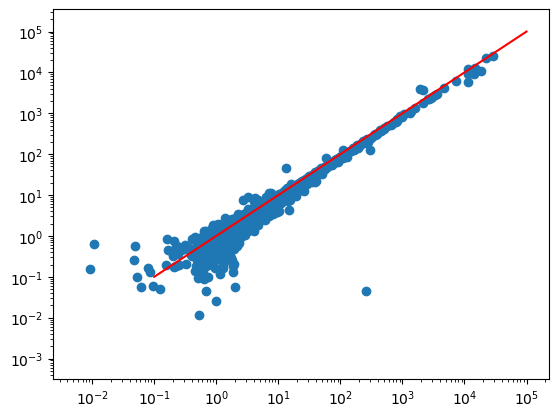

In [8]:
plt.scatter(fluxes['g'], fluxes['DES-G'])
plt.plot([1e-1, 1e5], [1e-1, 1e5], c='r')
plt.loglog()
plt.show()

In [13]:
filter_1 = 'DES-G'   # e.g., master_table column name
filter_2 = 'DES-R'
filter_3 = 'DES-R'
filter_4 = 'DES-I'

plot_error = False

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_3] / fluxes[filter_3])**2 +
        (sigmas[filter_4] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < 0.5) & (catalog['CLASS_STAR'] >= 0.0)

    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < .5)
    
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    )

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-3, 4)
    plt.ylim(-2.5, 4)
    plt.legend()
    plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[ 4.3180249   2.84266115  4.24801997  5.88866525  9.148102   14.56451451
  6.6176614   2.98627109  4.34165723  6.47545012 21.61587243 31.20327863
 37.72915693]
[ 0.99014028  3.13465631  4.290919    5.25947448  6.26236066  9.53930403
  8.29571153  2.33522539  4.21155804  3.64650197 10.13108569 15.86744014
 23.55489336]
[ 3.21569053  4.27841727  4.73164332  5.05426193  6.06149591  8.89718376
  6.78837545  3.05164932  5.4168843   5.28782871 13.68948081 20.80353719
 22.5549287 ]
[ 1.58653227  3.83532772  5.32984482  6.17090524  7.58950823 13.08276543
 10.47860943  2.60814274  5.13735809  4.7509268  12.04659267 19.72197344
 32.7917327 ]
[ 2.23445093  4.07446355  7.61332895  8.39550262  9.02239624 16.30463217
 10.46638114  3.42641942  5.86791567  8.14645852 10.9164377  18.24494645
 18.48318201]
[ 0.92597095  1.88907583  3.3941098   6.43718805  8.40328768 10.25877387
  6.77691169  1.6088992   3.26677829  8.16832315 12.28398652 17.76246916
 18.31871622]
[0.82232213 1.14127286 2.20049988 3.1263

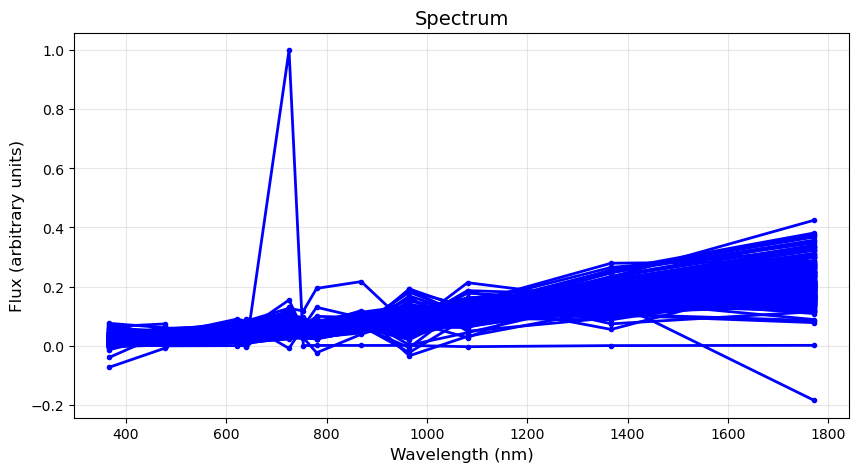

In [39]:
df = pd.DataFrame(fluxes)
sources_in_all_filters = df[df['u']!=0]
plt.figure(figsize=(10, 5))
for i in range(1100, 1300, 1):
    star = sources_in_all_filters.iloc[i]
    # Filters in correct spectral order (u → g → r → i → z → y → VIS → DES → NIR)
    filters = [
        'u', 'g', 'r', 'i', 'z', 'y',
        'VIS', 'DES-G', 'DES-R', 'DES-I',
        'NIR-Y', 'NIR-J', 'NIR-H'
    ]

    # Approximate effective wavelengths in nanometers
    # (values are typical for SDSS, DES, Euclid, NIR)
    wavelengths = np.array([
        (338+395)/2, (405+552)/2, (553+690)/2, (690+817)/2, (818+920)/2, (920+1010)/2,  # u g r i z y
        (550 + 900)/2,                                                                  # VIS (Euclid broad band)
        480, 640, 780,                                                                  # DES G R I
        1080.9, 1367.3, 1771.4                                                          # NIR Y J H
    ])
    order = np.argsort(wavelengths)
    fluxes_source = star[filters].values.astype(float)
    print(fluxes_source)
    # print(fluxes_source)
    # Mask invalid or zero fluxes
    mask = np.isfinite(fluxes_source) 
    # & (fluxes_source > 0)
    wavelengths = wavelengths[mask]
    fluxes_source = fluxes_source[mask]
    # print(sigmas)
    # sigmas = np.array([sigmas[filter] for filter in filters])

    # Plot
    plt.errorbar(wavelengths[order], fluxes_source[order]/np.sum(fluxes_source[order]), marker='.', linestyle='-', linewidth=2, c='b')
    # plt.fill_between(wavelengths[order], fluxes_source[order]/np.sum(fluxes_source[order]), alpha=0.2)  # spectrum-like shading

    plt.xlabel("Wavelength (nm)", fontsize=12)
    plt.ylabel("Flux (arbitrary units)", fontsize=12)
    plt.title(f"Spectrum", fontsize=14)
    plt.grid(alpha=0.3)
plt.show()